# Gaussian impurity sweeps

In [1]:
import kwant
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from amsc import (
    bulk_amsc_system,
    generate_intial_Delta,
    setup_gaussian_impurities,
)
from plot_tools import add_tl_label
from tqdm.notebook import tqdm
from pauli import *
from qm_tools import sparse_diag, sort_eigensystem

In [2]:
# eigsh = sla.eigsh
eigsh = sparse_diag  # MUMPS

In [3]:
plt.style.use("../plot_style.mplstyle")

# System Setup

In [9]:
periodic_bc = True

Nx = 71
Ny = 71

x_ax = np.linspace(-(Nx // 2), (Nx // 2), Nx)
y_ax = np.linspace(-(Ny // 2), (Ny // 2), Ny)
x, y = np.meshgrid(x_ax, y_ax)

t = 5.0
t_so = 0.0 * t
t_am = 0.25 * t

mu = 2.5
hz0 = 1e-6
hx0 = 0
hy0 = 0

## Initial value for Delta (will be used to determine g)
Delta_init = 1

In [10]:
vortex_positions = []
windings = []
l_core = 0  # l_core is the decay length of the order parameter (in a vortex that is the coherence length)

Delta, theta = generate_intial_Delta(
    x=x,
    y=y,
    Delta_init=Delta_init,
    vortex_positions=vortex_positions,
    windings=windings,
    l_core=l_core,
)

In [11]:
# Impurituy positions
impurity_positions = [(0, 0)]  # , (-10, 0)]
impurity_eccentricities = [0.0]  # Eccentricity
impurity_orientation = [0.0]  # Orientation

hx_imp = [0.0]  # Impurity field
hy_imp = [0.0]  # Impurity field
hz_imp = [0.0]  # Impurity field

In [12]:
N = 120

## Size

In [17]:
sizes = np.arange(0.8, 5.2, 0.2)
P = len(sizes)

wss = np.zeros((P, N))
vss = np.zeros((P, 4 * Nx**2, N), dtype=complex)

for i, size in tqdm(enumerate(sizes), total=len(sizes)):

    V, hx, hy, hz = setup_gaussian_impurities(
        x=x,
        y=y,
        mu=mu,
        hx0=hx0,
        hy0=hy0,
        hz0=hz0,
        impurity_sizes=[size],
        impurity_positions=impurity_positions,
        impurity_eccentricities=impurity_eccentricities,
        impurity_orientations=impurity_orientation,
        V_imp=[-17.5],
        hx_imp=hx_imp,
        hy_imp=hy_imp,
        hz_imp=hz_imp,
    )

    syst, lat = bulk_amsc_system(
        Nx=Nx,
        Ny=Ny,
        t=t,
        t_so=t_so,
        t_am=t_am,
        V=V,
        Delta=Delta,
        theta=theta,
        hx=hx,
        hy=hy,
        hz=hz,
        periodic_bc=periodic_bc,
    )

    fsyst = syst.finalized()

    ws, vs = eigsh(fsyst.hamiltonian_submatrix(sparse=True), k=N, sigma=0)

    wss[i] = ws
    vss[i] = vs

wss, vss = sort_eigensystem(wss, vss)

  0%|          | 0/22 [00:00<?, ?it/s]

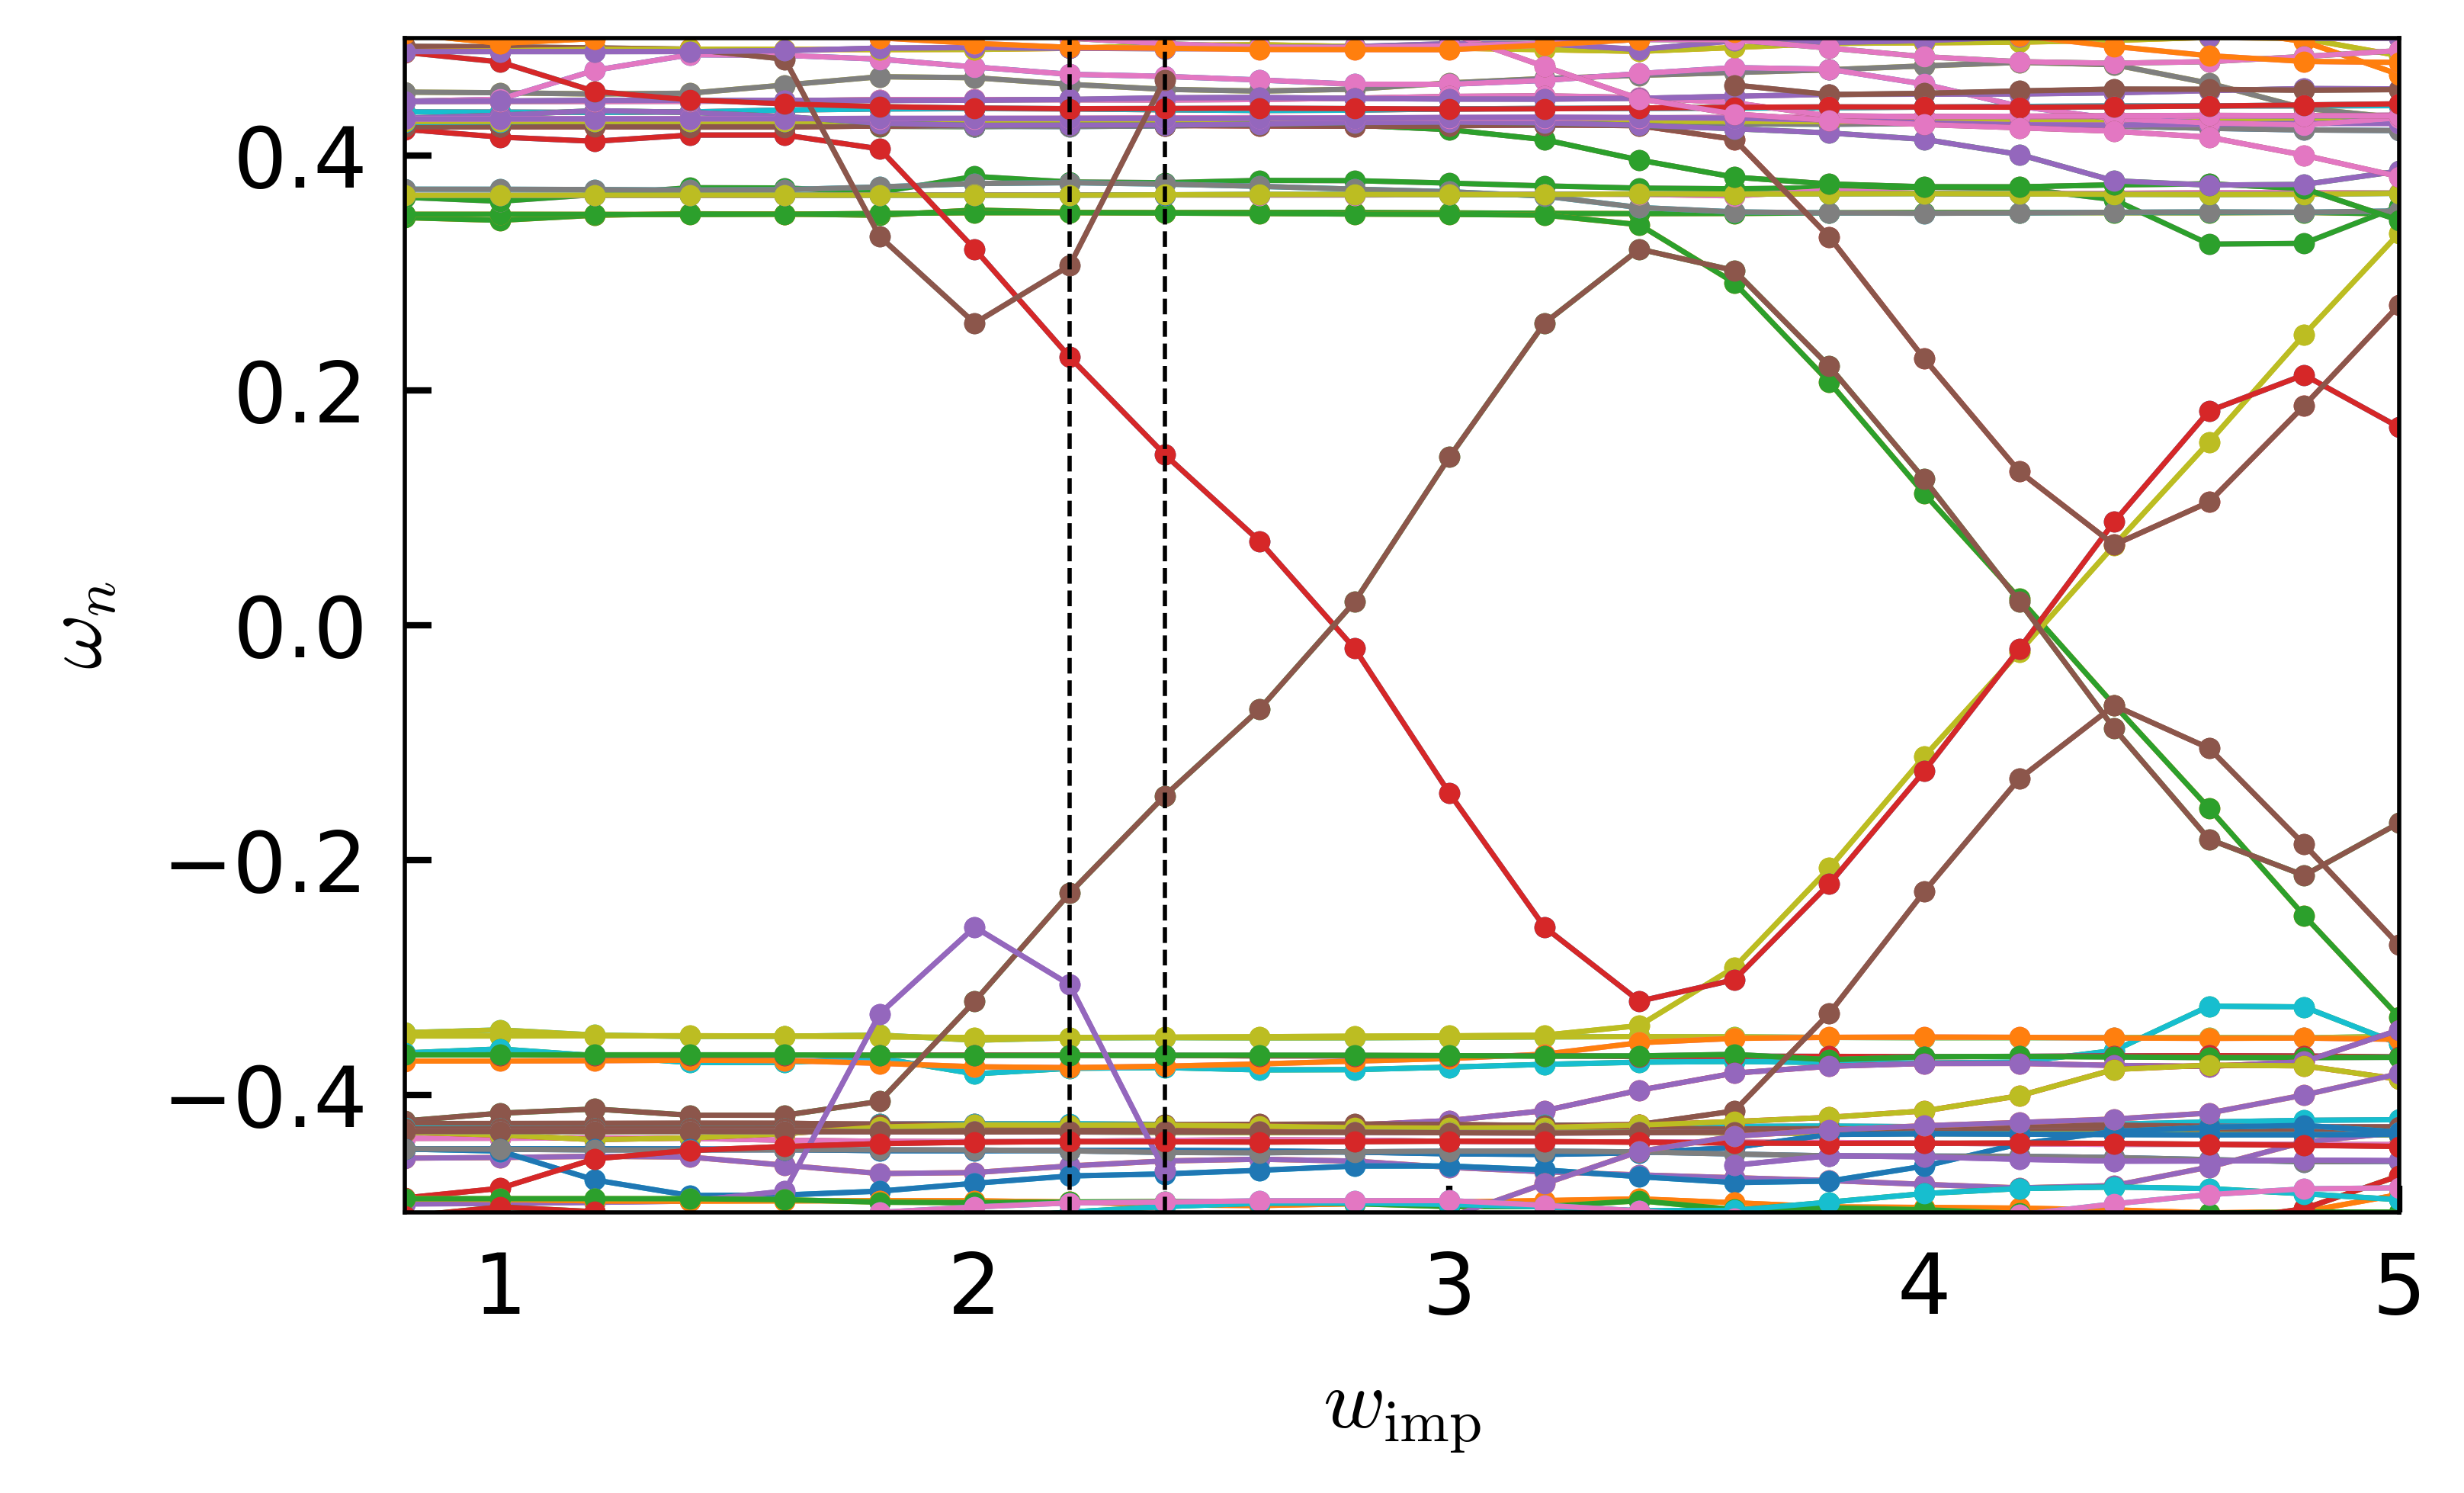

In [18]:
fig, ax = plt.subplots()

ri = np.linspace(0, 1, N)
np.random.shuffle(ri)
linecolors = mpl.cm.tab10(ri)

for i in range(N):
    ax.plot(sizes, wss[:, i], color=linecolors[i])

ax.set_xlabel(r"$w_\mathrm{imp}$")
ax.set_ylabel(r"$\omega_n$")

ax.vlines([2.2, 2.4], -0.5, 0.5, colors="k", linestyles="dashed", linewidth=0.4)
ax.set_ylim(-0.5, 0.5)
ax.set_xlim(0.8, 5)

fig.savefig("FigS1a-v175.svg")

In [22]:
P = 21
Vss = np.linspace(-10, -30, P)
wss = np.zeros((P, N))
vss = np.zeros((P, 4 * Nx**2, N), dtype=complex)

for i, Vs in tqdm(enumerate(Vss), total=len(Vss)):

    V, hx, hy, hz = setup_gaussian_impurities(
        x=x,
        y=y,
        mu=mu,
        hx0=hx0,
        hy0=hy0,
        hz0=hz0,
        impurity_sizes=[2.0],
        impurity_positions=impurity_positions,
        impurity_eccentricities=impurity_eccentricities,
        impurity_orientations=impurity_orientation,
        V_imp=[Vs],
        hx_imp=hx_imp,
        hy_imp=hy_imp,
        hz_imp=hz_imp,
    )

    syst, lat = bulk_amsc_system(
        Nx=Nx,
        Ny=Ny,
        t=t,
        t_so=t_so,
        t_am=t_am,
        V=V,
        Delta=Delta,
        theta=theta,
        hx=hx,
        hy=hy,
        hz=hz,
        periodic_bc=periodic_bc,
    )

    fsyst = syst.finalized()

    ws, vs = eigsh(fsyst.hamiltonian_submatrix(sparse=True), k=N, sigma=0)

    wss[i] = ws
    vss[i] = vs

wss, vss = sort_eigensystem(wss, vss)

  0%|          | 0/21 [00:00<?, ?it/s]

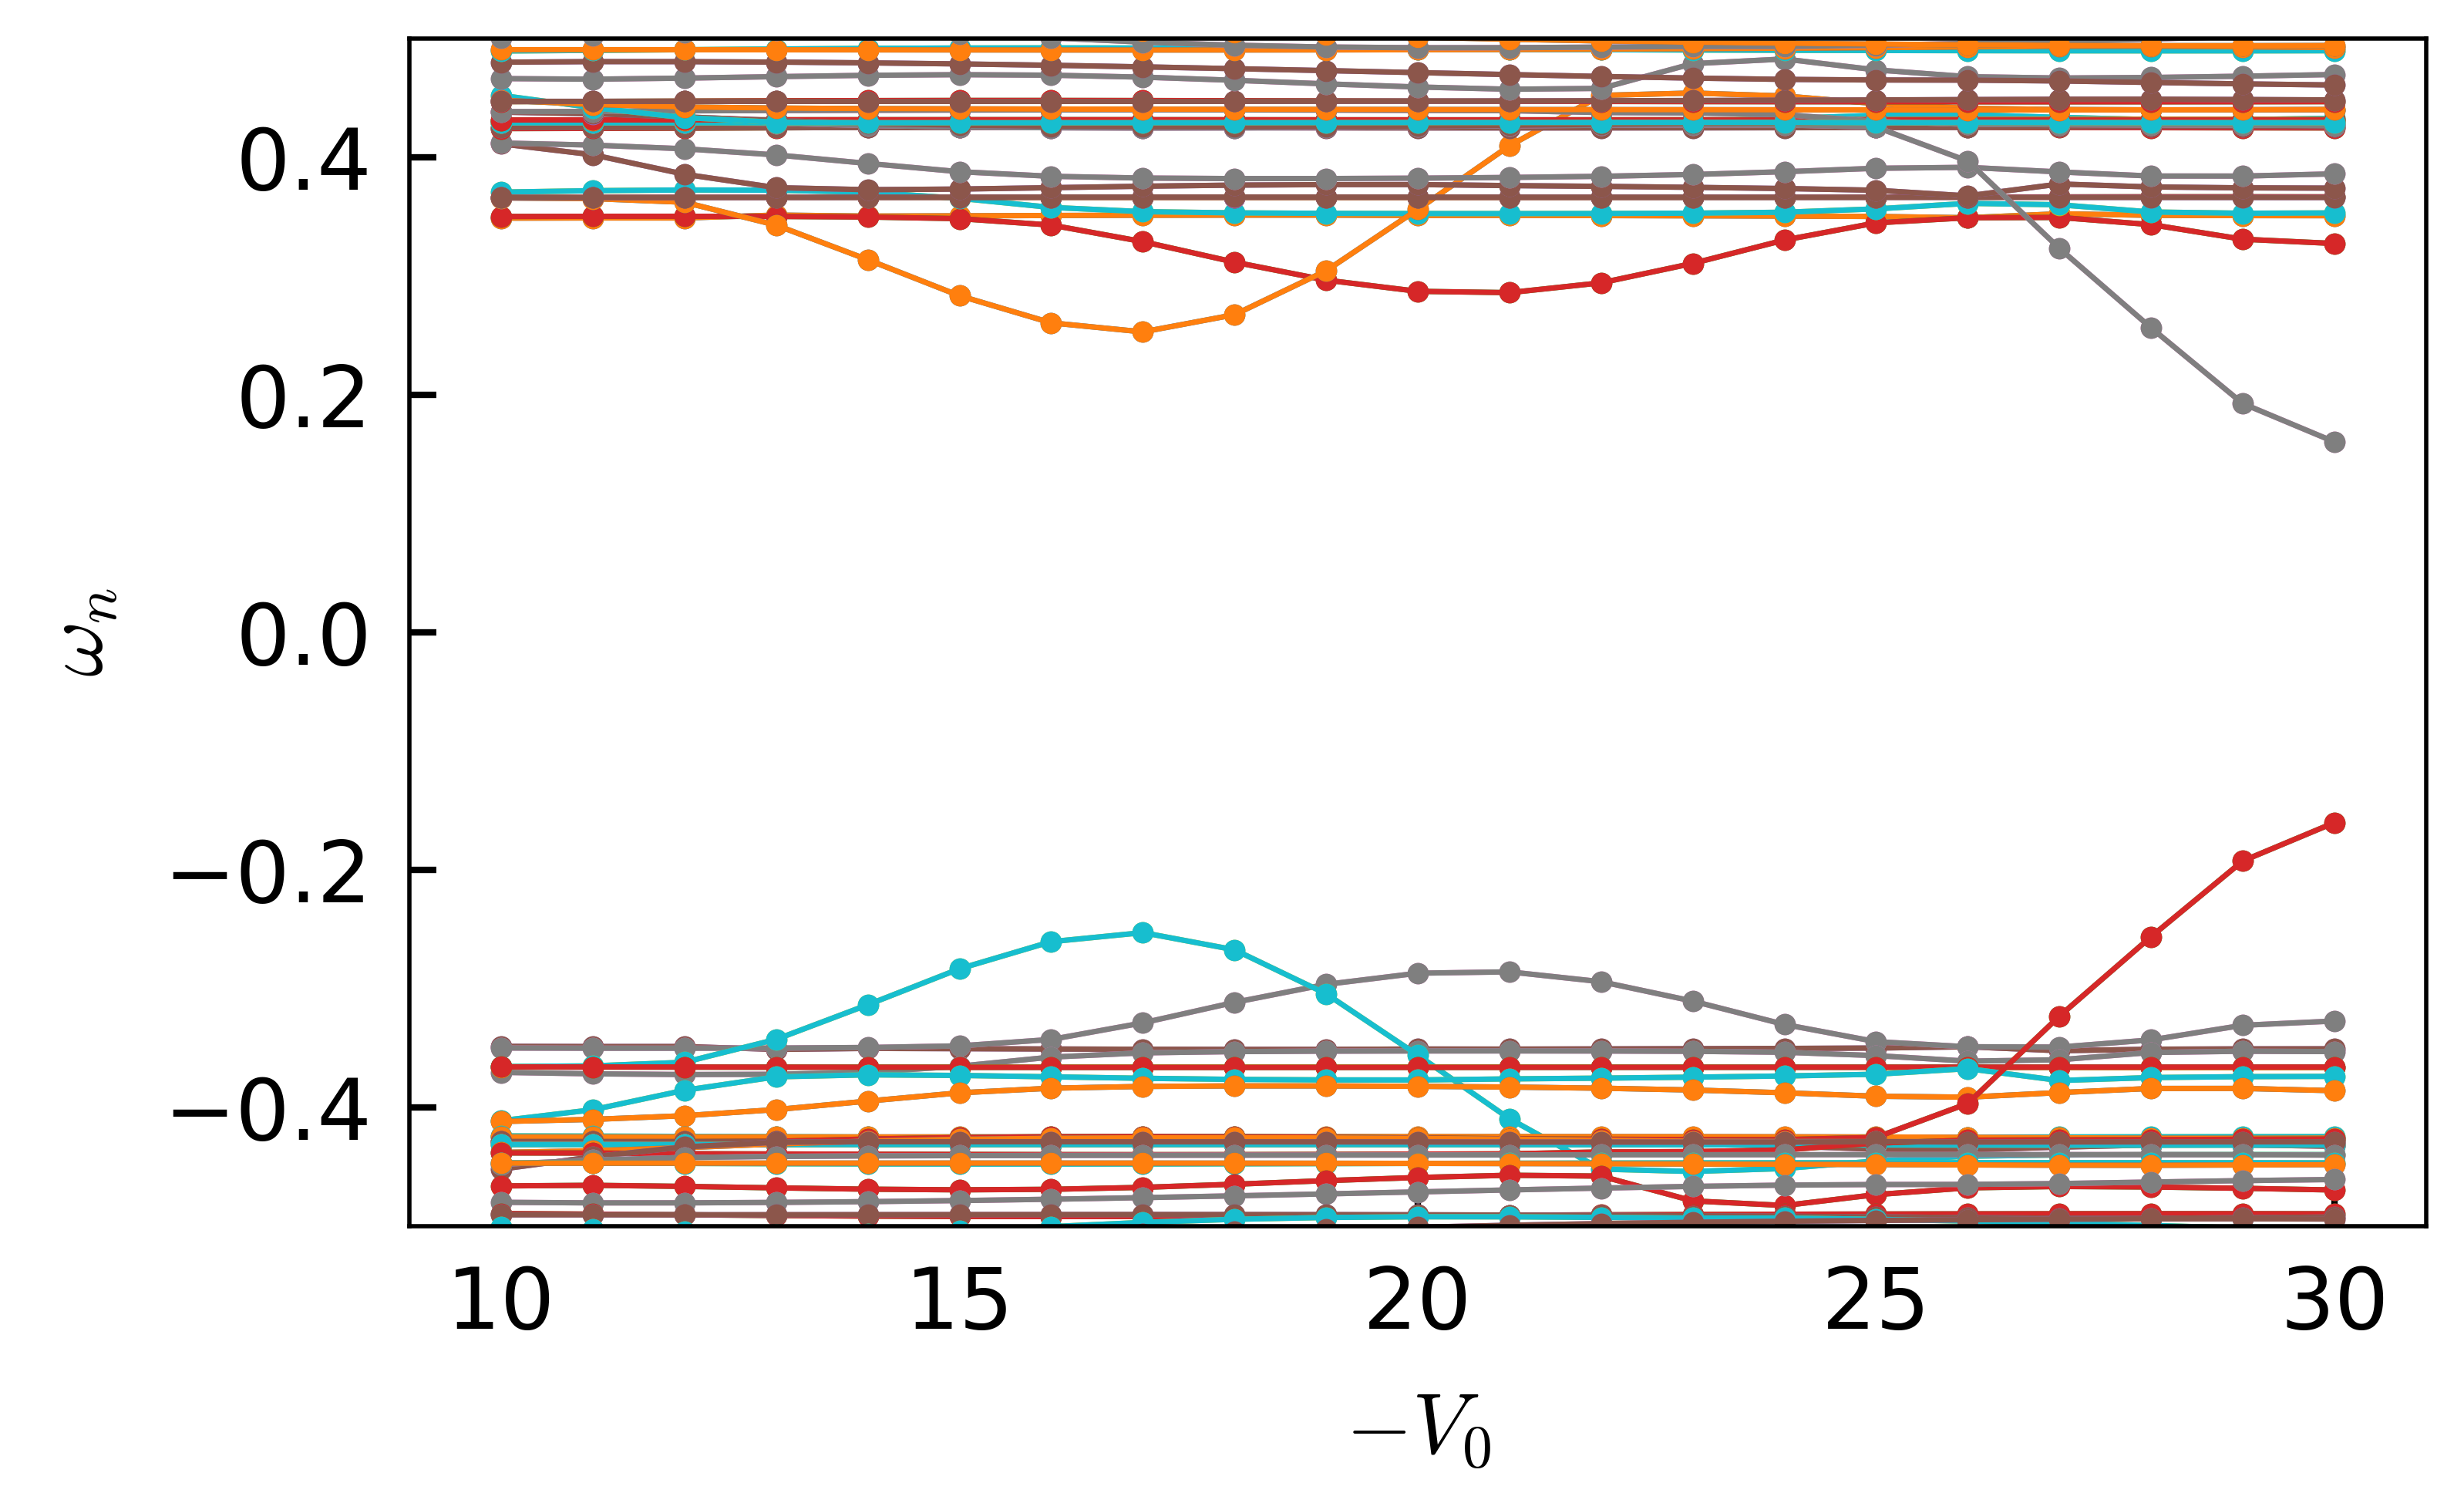

In [23]:
fig, ax = plt.subplots()
ax.plot(-Vss, wss)
ax.set_xlabel(r"$-V_0$")
ax.set_ylabel(r"$\omega_n$")

ax.set_ylim(-0.5, 0.5)
# ax.set_xlim(10, 30)

fig.savefig("FigS1b-20.svg")

## Non isotropic

In [13]:
P = 21
ecc = np.linspace(0, 0.9, P)
wss = np.zeros((P, N))
vss = np.zeros((P, 4 * Nx**2, N), dtype=complex)

for i, ec in tqdm(enumerate(ecc), total=len(ecc)):

    V, hx, hy, hz = setup_gaussian_impurities(
        x=x,
        y=y,
        mu=mu,
        hx0=hx0,
        hy0=hy0,
        hz0=hz0,
        impurity_sizes=[2.4],
        impurity_positions=impurity_positions,
        impurity_eccentricities=[ec],
        impurity_orientations=[0.0],
        V_imp=[-18],
        hx_imp=hx_imp,
        hy_imp=hy_imp,
        hz_imp=hz_imp,
    )

    syst, lat = bulk_amsc_system(
        Nx=Nx,
        Ny=Ny,
        t=t,
        t_so=t_so,
        t_am=t_am,
        V=V,
        Delta=Delta,
        theta=theta,
        hx=hx,
        hy=hy,
        hz=hz,
        periodic_bc=periodic_bc,
    )

    fsyst = syst.finalized()

    ws, vs = eigsh(fsyst.hamiltonian_submatrix(sparse=True), k=N, sigma=0)

    wss[i] = ws
    vss[i] = vs

wss, vss = sort_eigensystem(wss, vss)

  0%|          | 0/21 [00:00<?, ?it/s]

In [14]:
wss, vss = sort_eigensystem(wss, vss)

idxs = (abs(wss[0])).argsort()

t0sz_op = kwant.operator.Density(fsyst, onsite=t0sz, sum=False)

szs = np.zeros((P, N))

for n in range(N):
    for p in range(P):
        szs[p, n] = t0sz_op(vss[p, :, idxs[n]]).sum()

szs = szs.clip(-1, 1)

colors = np.zeros((P, N, 4))
colors[:] = (0.5, 0.5, 0.5, 0.5)

for p in range(P):
    for n in range(N):
        colors[p, idxs[n], :] = ((1 + szs[p, n]) / 2, 0, (1 - szs[p, n]) / 2, 1)

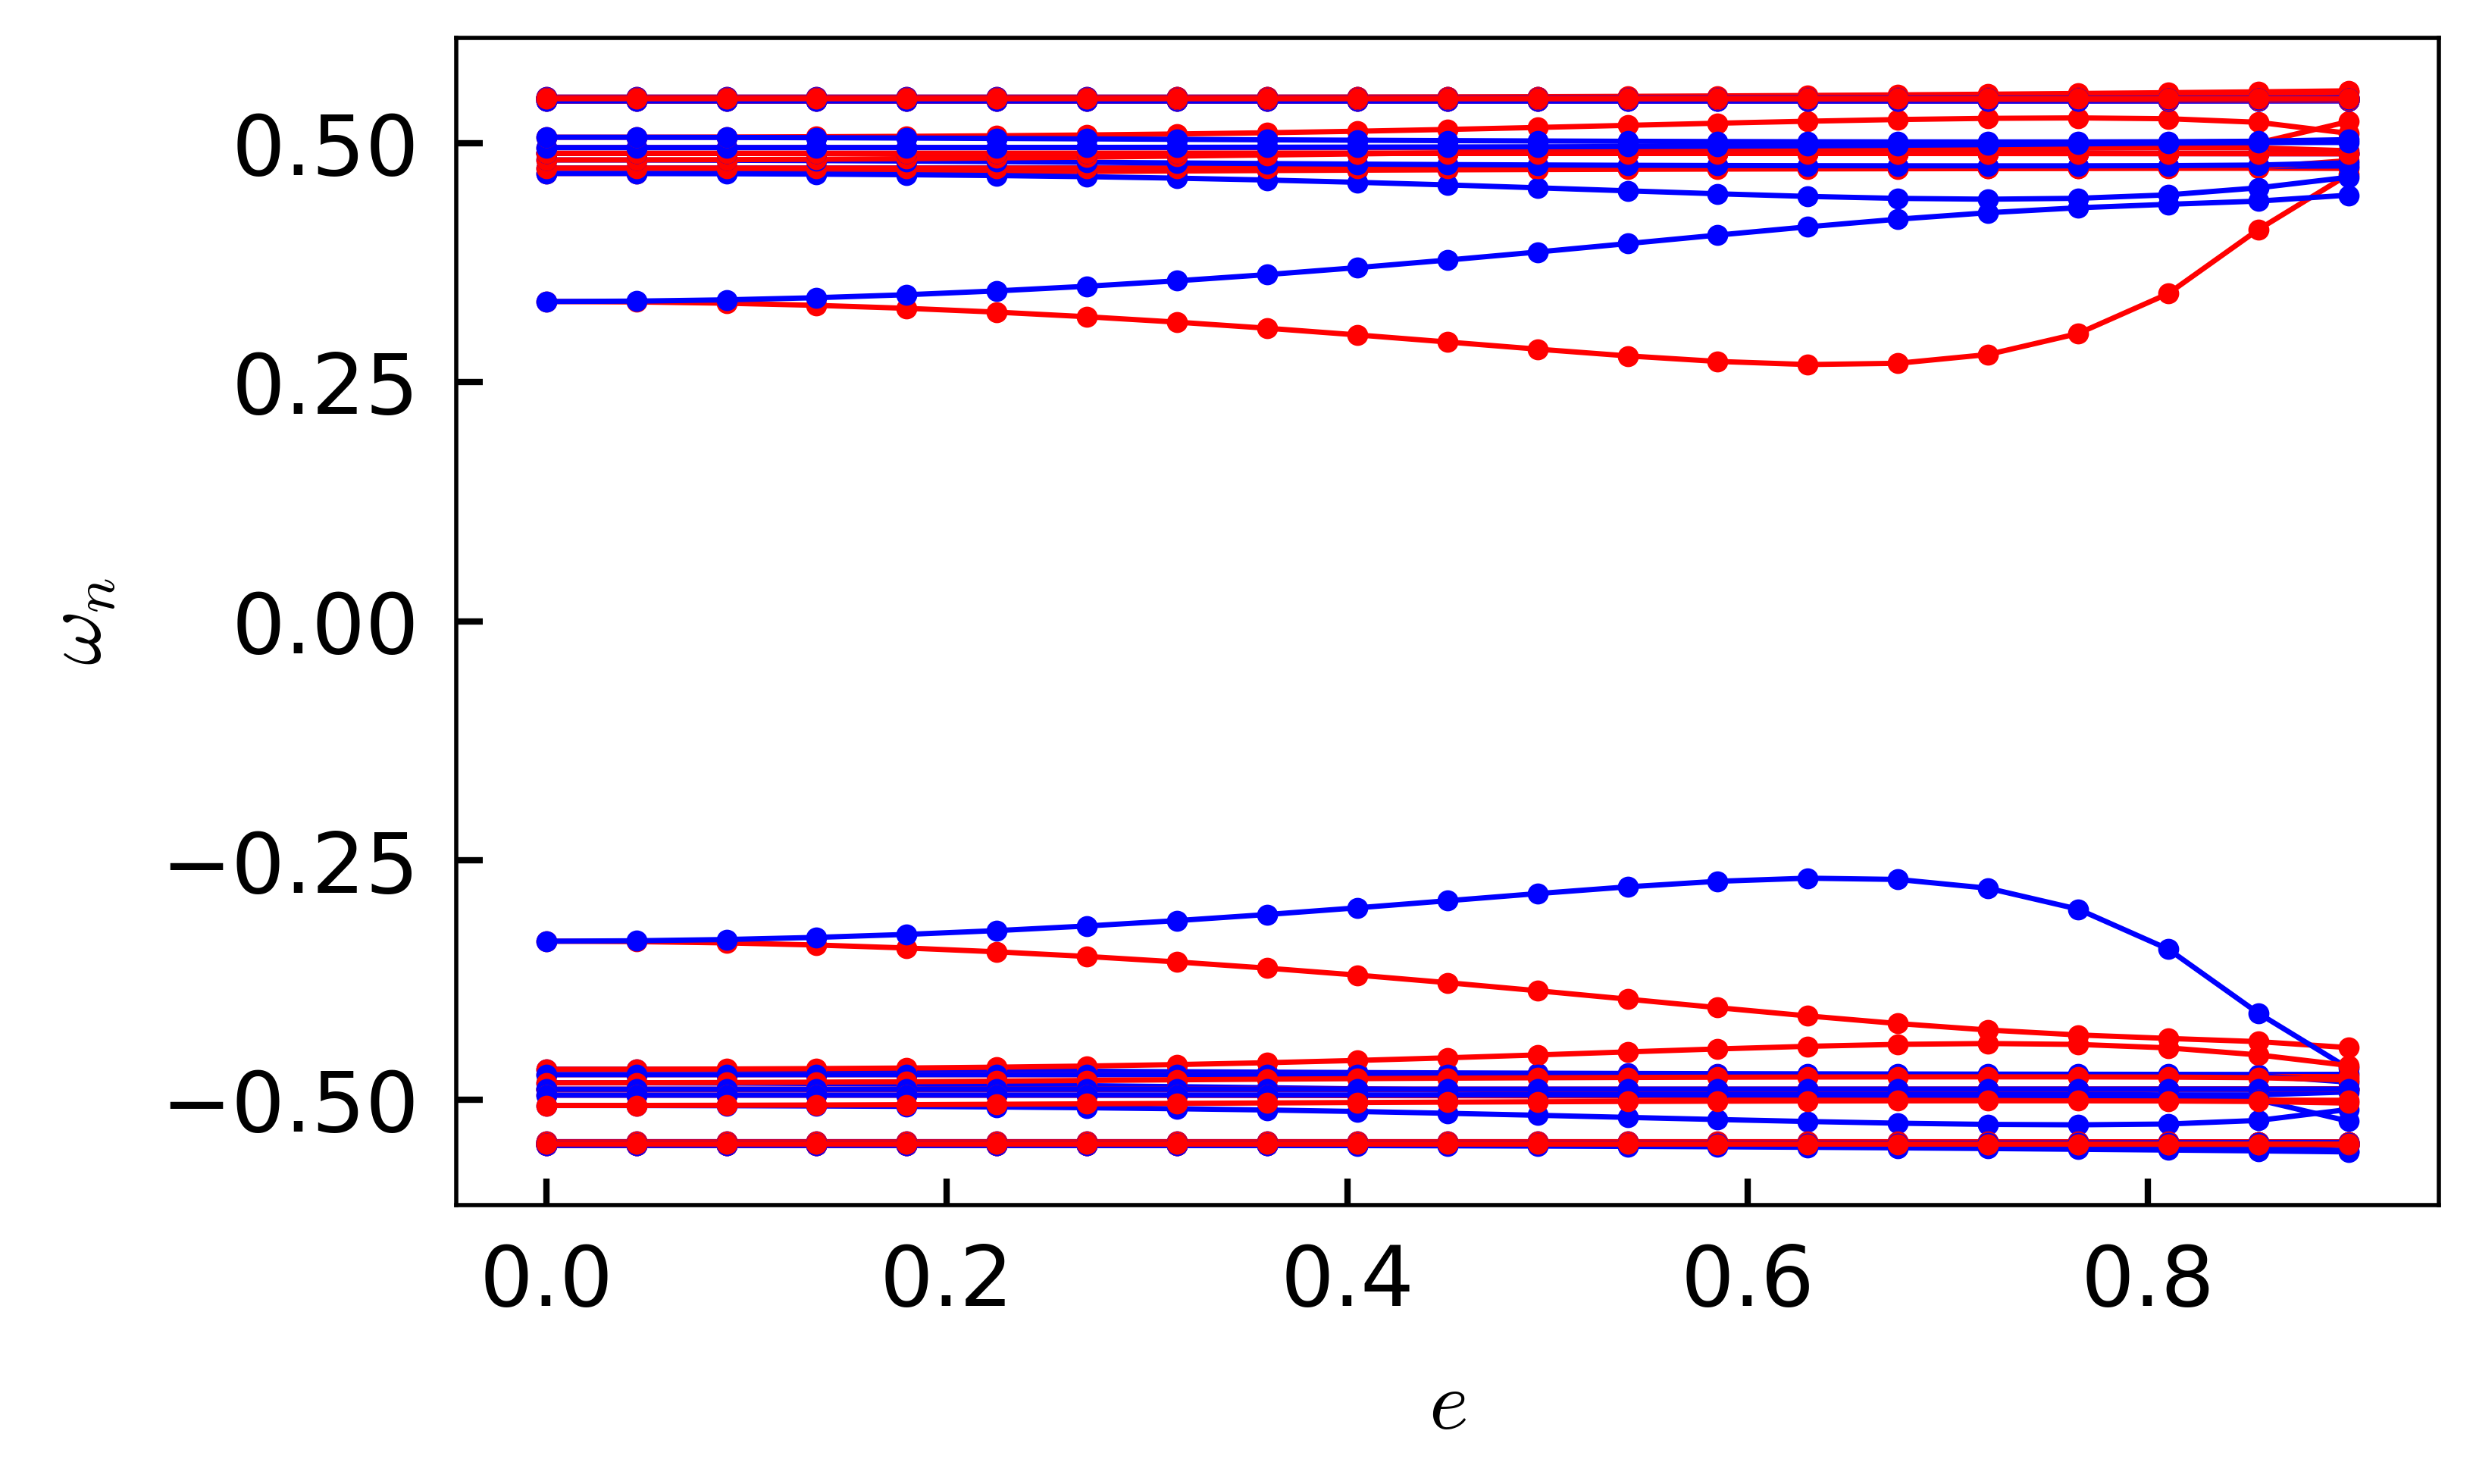

In [29]:
fig, ax = plt.subplots(figsize=(1.3, 1.3))

for n in range(N):
    ax.plot(ecc, wss[:, n], "-", color=colors[0, n])


ax.plot(ecc, Delta_init - mu * t_am / t, "-.", color="green")
ax.plot(ecc, -Delta_init + mu * t_am / t, "-.", color="green")

ax.set_xlabel(r"$e$", labelpad=-8)
ax.set_ylabel(r"$\omega_n$", labelpad=-8)

ax.set_xticks([0, 0.4, 0.8], labels=["0", "", "0.8"])
ax.set_yticks([0, 0.2, 0.4], labels=["0", "", "0.4"])

ax.set_xlim(0, 0.9)
ax.set_ylim(-0.5, 0.5)

fig.savefig("noniso.svg")
fig.savefig("FigS2a.pdf")

In [ ]:
P = 21
phis = np.linspace(0, np.pi / 2, P)
wss = np.zeros((P, N))
vss = np.zeros((P, 4 * Nx**2, N), dtype=complex)

for i, Vs in tqdm(enumerate(Vss), total=len(Vss)):

    V, hx, hy, hz = setup_gaussian_impurities(
        x=x,
        y=y,
        mu=mu,
        hx0=hx0,
        hy0=hy0,
        hz0=hz0,
        impurity_sizes=[2],
        impurity_positions=impurity_positions,
        impurity_eccentricities=[0.5],
        impurity_orientations=phis,
        V_imp=[-15],
        hx_imp=hx_imp,
        hy_imp=hy_imp,
        hz_imp=hz_imp,
    )

    syst, lat = bulk_amsc_system(
        Nx=Nx,
        Ny=Ny,
        t=t,
        t_so=t_so,
        t_am=t_am,
        V=V,
        Delta=Delta,
        theta=theta,
        hx=hx,
        hy=hy,
        hz=hz,
        periodic_bc=periodic_bc,
    )

    fsyst = syst.finalized()

    ws, vs = eigsh(fsyst.hamiltonian_submatrix(sparse=True), k=N, sigma=0)

    wss[i] = ws
    vss[i] = vs

wss, vss = sort_eigensystem(wss, vss)